<a href="https://colab.research.google.com/github/sakshisinha-13/Unveiling-Global-CPI-Trends-and-Inflation-Patterns-for-Strategic-Insights/blob/main/Unveiling_Global_CPI_Trends_and_Inflation_Patterns_for_Strategic_Insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Loading and Preprocessing**

In [44]:
#Importing Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from scipy.stats import pearsonr


In [45]:
# Loading Dataset
file_path = '/content/sample_data/consumer_price_index.csv'  # Adjust as per your file path
cpi_data = pd.read_csv(file_path)

# Reshaping the Data (Wide to Long Format)
cpi_data_long = pd.melt(
    cpi_data,
    id_vars=['REF_AREA', 'Reference area', 'UNIT_MEASURE', 'Unit of measure'],  # Identifier columns
    var_name='Date',  # Column name for dates
    value_name='CPI'  # Column name for CPI values
)

# Converting 'Date' to datetime format
cpi_data_long['Date'] = pd.to_datetime(cpi_data_long['Date'], format='%Y-%m', errors='coerce')

# Converting CPI column to numeric
cpi_data_long['CPI'] = pd.to_numeric(cpi_data_long['CPI'], errors='coerce')

# Handling Missing Values
cpi_data_long['CPI'] = cpi_data_long['CPI'].fillna(method='ffill')  # Forward fill missing CPI values


<ipython-input-45-4e70da485106>:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cpi_data_long['CPI'] = cpi_data_long['CPI'].fillna(method='ffill')  # Forward fill missing CPI values


# **Calculating Inflation Rate**

In [46]:
# Grouping by Region and Computing Inflation Rates
cpi_data_long['InflationRate'] = (
    cpi_data_long.groupby('REF_AREA', group_keys=False)['CPI']
    .apply(lambda x: x.pct_change() * 100)
)

# Handling Infinite and Missing Values in Inflation Rate
cpi_data_long['InflationRate'] = cpi_data_long['InflationRate'].replace([float('inf'), -float('inf')], pd.NA)
cpi_data_long['InflationRate'] = cpi_data_long['InflationRate'].fillna(0)  # Replace NaNs with 0


<ipython-input-46-f390e26b459b>:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cpi_data_long['InflationRate'] = cpi_data_long['InflationRate'].fillna(0)  # Replace NaNs with 0


# **Saving and Storing Data**

In [47]:
# Saving Cleaned Data
cpi_data_long.to_csv('cleaned_cpi_data.csv', index=False)


In [48]:
# Storing Data in SQL Database
conn = sqlite3.connect('cpi_analysis.db')
cpi_data_long.to_sql('CPI', conn, if_exists='replace', index=False)

432180

# **Querying Data with SQL**

In [49]:
# SQL Queries
query_1 = "SELECT REF_AREA, AVG(CPI) AS AvgCPI FROM CPI GROUP BY REF_AREA ORDER BY AvgCPI DESC;"
query_2 = "SELECT REF_AREA, MAX(InflationRate) AS MaxInflation FROM CPI GROUP BY REF_AREA ORDER BY MaxInflation DESC;"
query_3 = """
SELECT Date, REF_AREA, AVG(CPI) AS AvgCPI
FROM CPI
WHERE `Unit of measure` IS NOT NULL
GROUP BY Date, REF_AREA
ORDER BY Date;
"""
result_1 = pd.read_sql(query_1, conn)
result_2 = pd.read_sql(query_2, conn)
result_3 = pd.read_sql(query_3, conn)

# Printing SQL Query Results
print("Average CPI by Region:\n", result_1.head())
print("Regions with the Highest Inflation:\n", result_2.head())
print("Average CPI Trends by Date and Region:\n", result_3.head())

Average CPI by Region:
   REF_AREA        AvgCPI
0       RS  1.802379e+06
1       PE  9.737932e+05
2       IT  8.285033e+05
3       AR  8.559252e+01
4       BR  4.548948e+01
Regions with the Highest Inflation:
   REF_AREA  MaxInflation
0       PT  1.435757e+16
1       SA  8.796404e+15
2       CO  8.796404e+15
3       AR  8.796404e+15
4       LV  1.820205e+15
Average CPI Trends by Date and Region:
    Date REF_AREA     AvgCPI
0  None       AE   6.012914
1  None       AR  20.705479
2  None       AT   7.742410
3  None       AU   6.566967
4  None       BE   7.281555


# **Statistical Analysis**

In [50]:
# Calculating Correlation Between CPI and Inflation Rate
valid_data = cpi_data_long.dropna(subset=['CPI', 'InflationRate'])
correlation = pearsonr(valid_data['CPI'], valid_data['InflationRate'])
print("Correlation between CPI and Inflation Rate:", correlation)


Correlation between CPI and Inflation Rate: PearsonRResult(statistic=-8.017090609806953e-05, pvalue=0.9580985734147108)


# **Data Visualization**

<ipython-input-51-8aadd231824a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['CPI'] = pd.to_numeric(filtered_data['CPI'], errors='coerce')


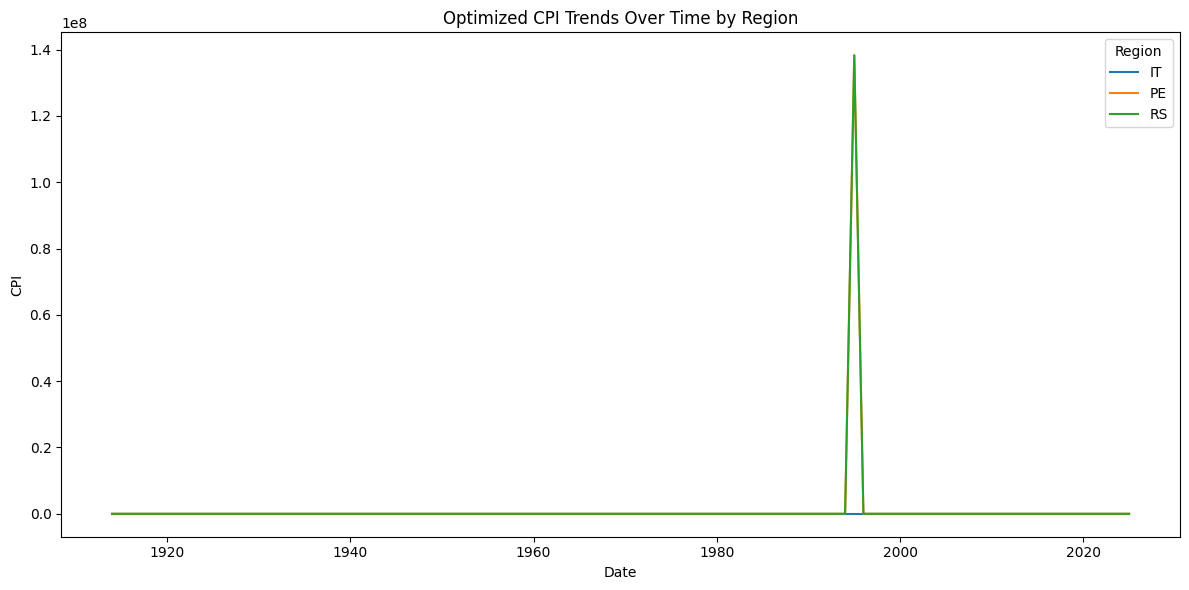

In [51]:
# Selecting a Few Regions of Interest (e.g., Top 3 Regions)
top_regions = cpi_data_long.groupby('REF_AREA')['CPI'].mean().nlargest(3).index
filtered_data = cpi_data_long[cpi_data_long['REF_AREA'].isin(top_regions)]

# Ensure=ing 'CPI' column is numeric and drop non-numeric rows
filtered_data['CPI'] = pd.to_numeric(filtered_data['CPI'], errors='coerce')
filtered_data = filtered_data.dropna(subset=['CPI'])

# Downsample Data to Yearly Averages (Use 'YE' Instead of 'Y')
filtered_data = (
    filtered_data.groupby(['REF_AREA', pd.Grouper(key='Date', freq='YE')])
    .mean(numeric_only=True)  # Ensure only numeric columns are aggregated
    .reset_index()
)

# Using Matplotlib for Simpler Plotting
plt.figure(figsize=(12, 6))
for region in filtered_data['REF_AREA'].unique():
    region_data = filtered_data[filtered_data['REF_AREA'] == region]
    if not region_data.empty:
        plt.plot(region_data['Date'], region_data['CPI'], label=region)

# Customize Plot
plt.title('Optimized CPI Trends Over Time by Region')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend(title='Region')
plt.tight_layout()
plt.show()


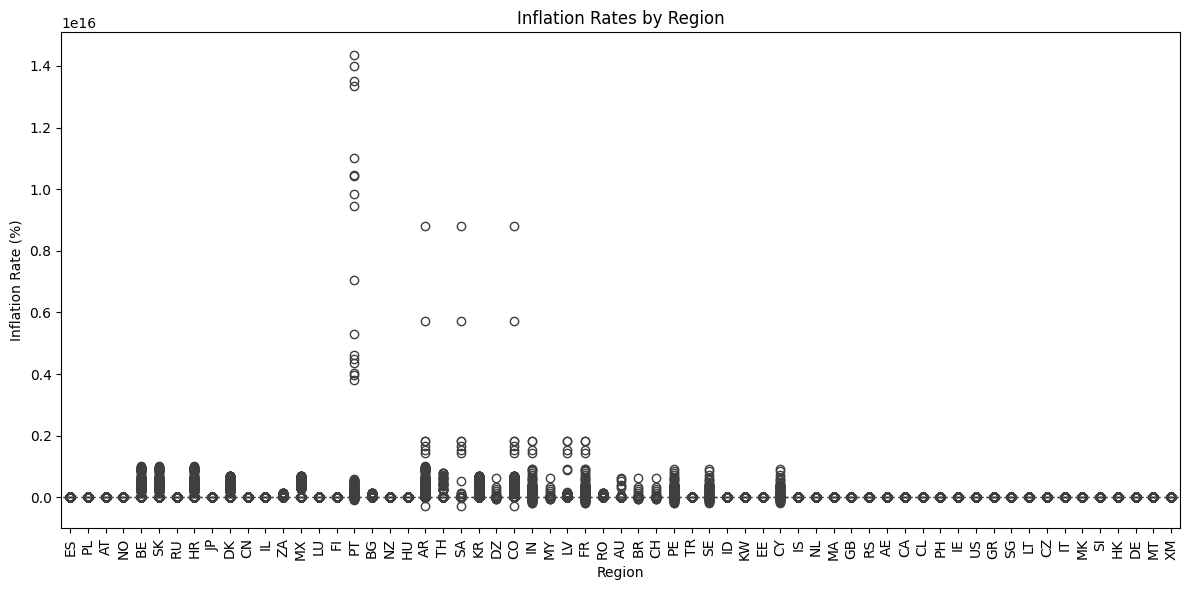

In [52]:
#Box Plot for Inflation Rates by Region
plt.figure(figsize=(12, 6))
sns.boxplot(data=cpi_data_long, x='REF_AREA', y='InflationRate')
plt.title('Inflation Rates by Region')
plt.xlabel('Region')
plt.ylabel('Inflation Rate (%)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


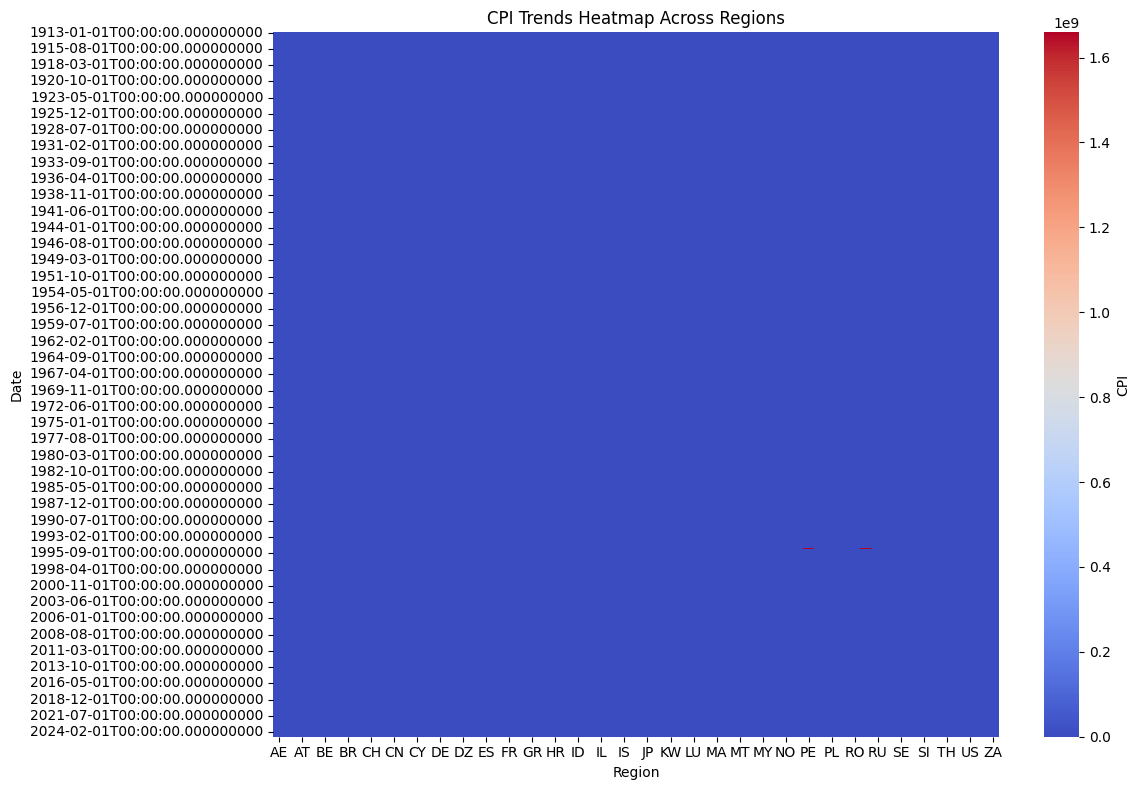

In [53]:
#Heatmap for CPI Trends Across Regions and Time
cpi_pivot = cpi_data_long.pivot_table(index='Date', columns='REF_AREA', values='CPI', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(cpi_pivot, cmap='coolwarm', cbar_kws={'label': 'CPI'})
plt.title('CPI Trends Heatmap Across Regions')
plt.xlabel('Region')
plt.ylabel('Date')
plt.tight_layout()
plt.show()


<ipython-input-54-1456b53f13bd>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


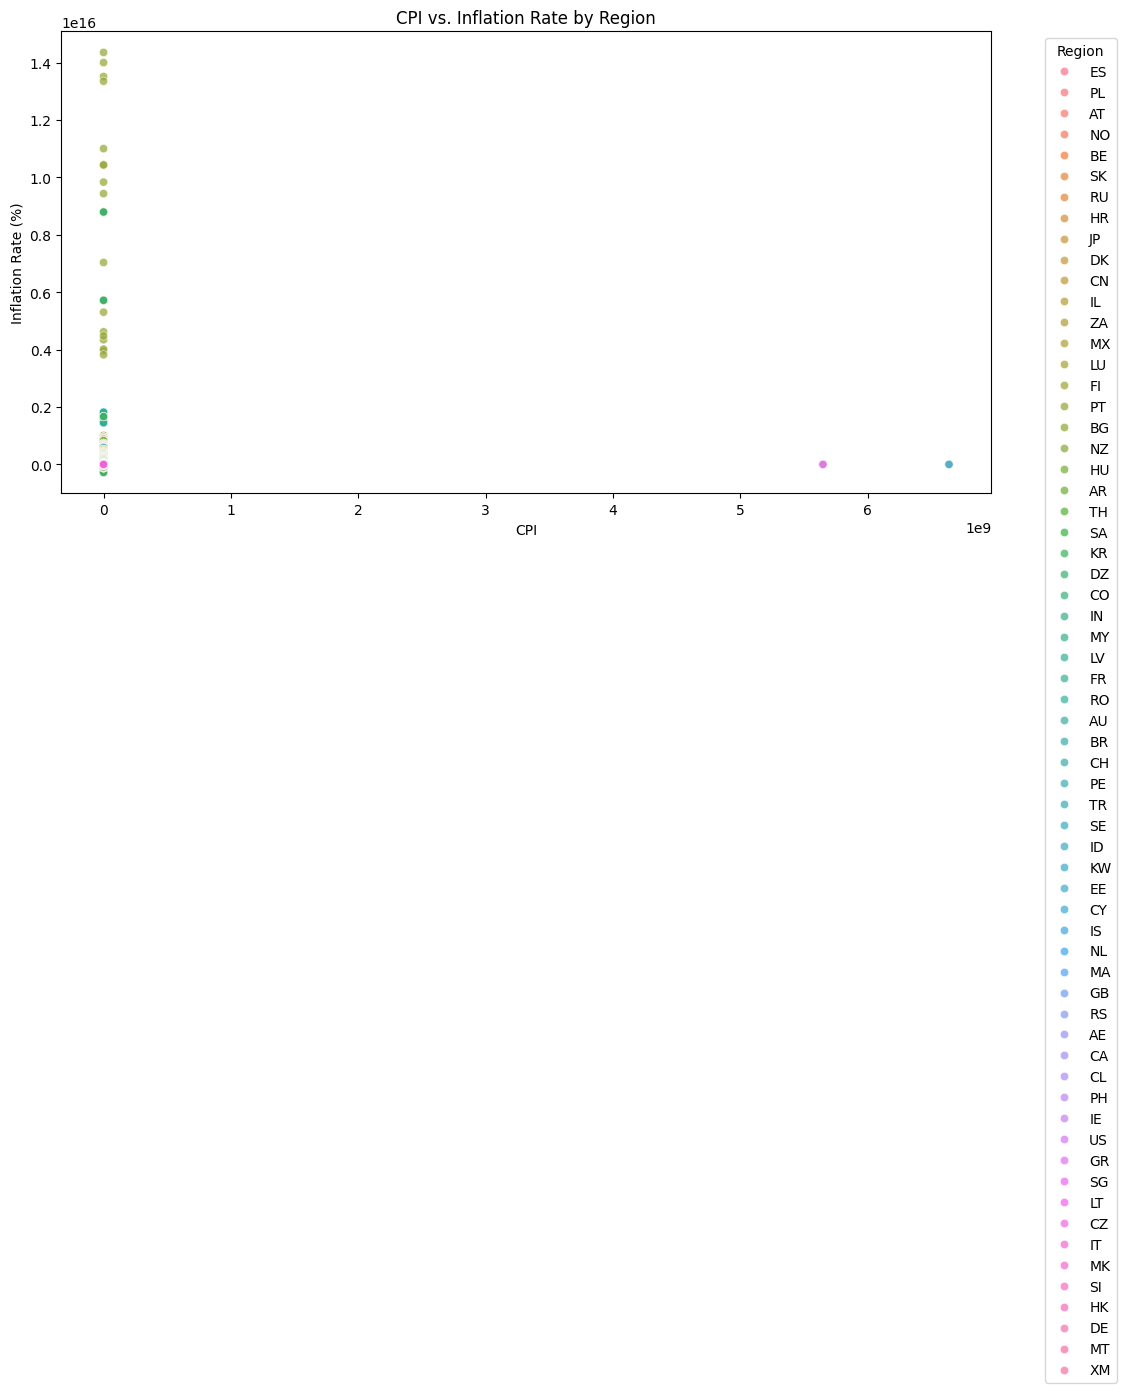

In [54]:
#Scatter Plot for CPI vs. Inflation Rate
plt.figure(figsize=(12, 6))
sns.scatterplot(data=cpi_data_long, x='CPI', y='InflationRate', hue='REF_AREA', alpha=0.7)
plt.title('CPI vs. Inflation Rate by Region')
plt.xlabel('CPI')
plt.ylabel('Inflation Rate (%)')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
